In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import WhisperProcessor, WhisperForConditionalGeneration

from tqdm import tqdm
import importlib

import audio_utils as audio

In [3]:
dataset = load_from_disk("./tedlium/validation.hf").with_format("torch").select(range(100))

In [5]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en", output_attentions=True).to("cuda")
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def inference(audio_tensor, model, processor, is_longform=False, skip_special_tokens=False):
    if not is_longform:
        inputs = processor(audio_tensor, return_tensors="pt", sampling_rate=16_000)
        input_features = inputs.input_features.to(model.device)
        res = model.generate(input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res["sequences"], skip_special_tokens=skip_special_tokens)
        return (decoded[0], res.encoder_attentions, res.decoder_attentions, res.cross_attentions)
    else:
        inputs = processor(audio_tensor, return_tensors="pt", truncation=False, padding="longest", return_attention_mask=True, sampling_rate=16_000)
        input_features = inputs.to(model.device)
        res = model.generate(**input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res, skip_special_tokens=skip_special_tokens)
        return (decoded[0], None, None, None)

In [58]:
print(dataset[1], dataset[1]["audio"].shape[0] / 16000)

{'audio': tensor([ 0.0564,  0.0104, -0.0457,  ..., -0.0081, -0.0129, -0.0132]), 'text': 'i want to start out by asking you to think back to when you were a kid playing with blocks as you figured out how to reach out and grasp pick them up and move them around you were actually learning how to think and solve problems by understanding and manipulating spatial relationships'} 14.14


In [59]:
example = dataset[1]["audio"]

In [60]:
audio.play_audio(example)

In [61]:
res, e_attns, d_attns, c_attns = inference(example, model, processor, skip_special_tokens=True)

In [20]:
res.strip().split()

['This',
 'question',
 'was',
 'so',
 'compelling',
 'that',
 'we',
 'decided',
 'to',
 'explore',
 'the',
 'answer',
 'by',
 'building',
 'sytables.']

In [10]:
def plot_attns(attns, rows, cols, figsize=(30, 10), filename=None):
    attns = [a.cpu().squeeze(0) for a in attns]
    blocks = len(attns)
    heads = attns[0].size(0)
    assert rows * cols == blocks * heads
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    pbar = tqdm(range(blocks * heads), leave=True, ncols=0)
    
    for idx in pbar:
        i, j = idx // cols, idx % cols
        x, y = idx // heads, idx % heads
        sns.heatmap(attns[x][y,:,:], cmap="viridis", ax=ax[i][j])
        ax[i][j].set_title(f"Block {x + 1} Head {y + 1}")
        pbar.refresh()

    # plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

In [13]:
filename = None

encoder_filename = None if not filename else filename + "_encoder.png"
encoder_truncated_filename = None if not filename else filename + "_encoder_truncated.png"
decoder_filename = None if not filename else filename + "_decoder.png"
cross_filename = None if not filename else filename + "_cross.png"
cross_truncated_filename = None if not filename else filename + "_cross_truncated.png"

# Encoder Attentions

In [11]:
list(map(lambda x: x.size(), e_attns))

[torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500])]

In [62]:
encoder_limit = int(example.size(0) / 16000 * 50) + 1
encoder_limit

708

In [ ]:
plot_attns(torch.stack(e_attns), 8, 3, figsize=(30, 80), filename=encoder_filename)

In [ ]:
plot_attns(torch.stack(e_attns).squeeze()[:, :, :encoder_limit, :encoder_limit], 8, 3, figsize=(30, 80), filename=encoder_truncated_filename)

# Decoder Attentions

In [ ]:
list(map(lambda x: tuple(map(lambda y: y.size(), x)), d_attns))

In [210]:
d_attns_stacked = [F.pad(torch.stack(d).squeeze(), (0, d_attns[-1][-1].size(3) - d[-1].size(3), 0, 0), "constant", 0.0) for d in d_attns[1:]]

In [214]:
d_attns_nett = torch.stack(d_attns_stacked).permute(1, 2, 0, 3)
d_attns_nett.shape

torch.Size([4, 6, 18, 20])

In [ ]:
plot_attns(d_attns_nett, 6, 4, figsize=(40, 60), filename=decoder_filename)

# Cross Attentions

In [63]:
c_attns_stacked = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)

In [ ]:
plot_attns(c_attns_stacked, 8, 3, figsize=(30, 80), filename=cross_filename)

100% 24/24 [00:38<00:00,  1.61s/it]


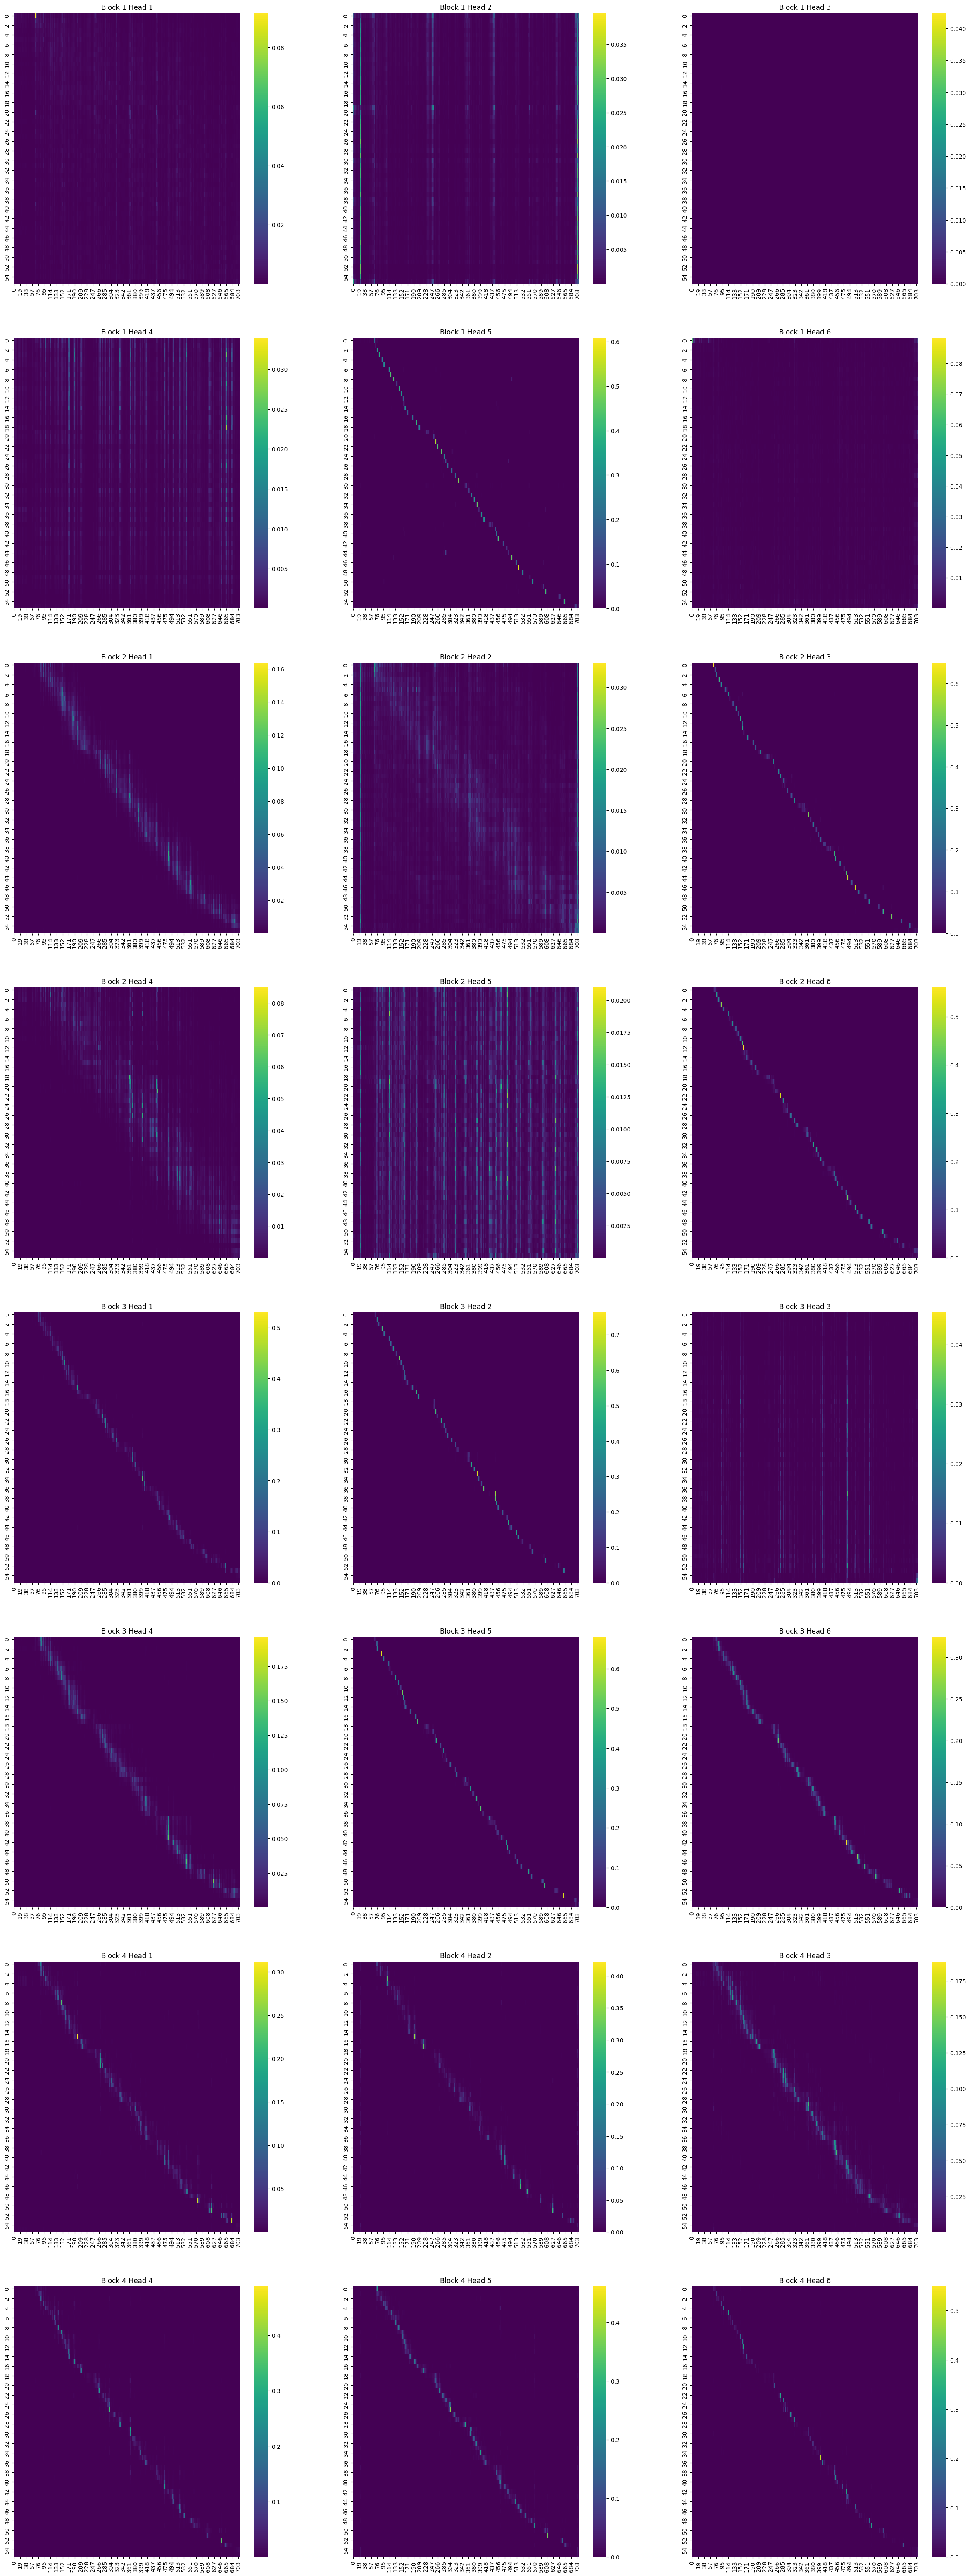

In [64]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit]
plot_attns(c_attns_stacked_cutoff, 8, 3, figsize=(30, 80), filename=cross_truncated_filename)

In [89]:
def get_timestamp(audio, attn, lim):
    maxi, mini = attn.max(), attn.min()
    normalised_attn = (attn - mini) / (maxi - mini)
    masked = torch.where(normalised_attn >= lim, 1.0, 0.0)
    indices = masked.nonzero()[:, 1].unique().cpu()
    seconds = indices * 0.02 * 16_000
    return seconds

def plot_spikes(audio, attn, lim, figsize=(20, 6)):
    seconds = get_timestamp(audio, attn, lim)
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.heatmap(attn.cpu(), cmap="viridis", ax=ax[0])
    ax[1].plot(audio)
    ax[1].vlines(seconds, -1, 1, color="r")

    plt.show()

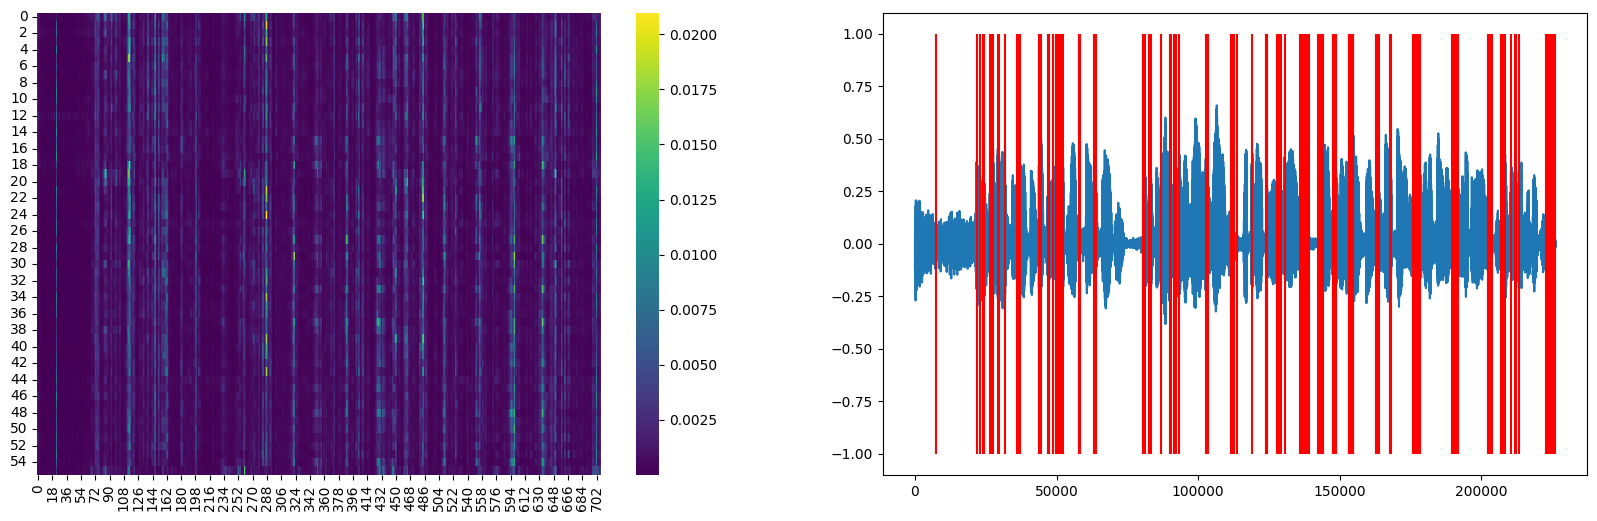

In [90]:
plot_spikes(example, c_attns_stacked_cutoff[1, 4], 0.2)

In [59]:
audio.play_audio(example[start:])